## Program for Exercise 4 - Fuzzy Logic
This program is made to replicate the fuzzy controller system "Temperature Control in a Shower", witch is an example system
made by [MATLAB](https://www.mathworks.com/help/fuzzy/temperature-control-in-a-shower.html).
The program can use both the Mamdani and the Sugeno method.

In [16]:
# Import the packages used in the project
import simpful as fs  # changed line 149 to show(block=False) (in simpful.py)
from matplotlib import pylab as plt
import numpy as np
from scipy import signal as sig

Sugeno interference can be enabled by changing this flag to TRUE

In [17]:
# Enable Sugeno inference
enable_sugeno = False

In [18]:
def surface_plot_3d(sys, ling_vars: list, domain=None, divisions=20, sugeno=False, computation_only=False):
    """
    Function to generate the inference datapoint in ranges, it can either make the surface plot
    or return the data points
    :param sys: The fuzzy system to infer
    :param ling_vars: Array containing all the names of the linguistic variables (2 inputs and 1 output)
    :param domain: Array to limit the plot to a given domain
    :param divisions: Number of devisons to calculate in the plot
    :param sugeno: Set to true to use Sugeno inference
    :param computation_only: Set to true to return the data points instead of plotting
    :return: xs, ys, zs: (only if computation_only is TRUE), the data points as numpy arrays
    """
    #
    if domain is None:
        domain = [[0, 1], [0, 1], [0, 1]]
    xs = []
    ys = []
    zs = []
    DIVs = divisions
    # Calculate all the data points
    for x in np.linspace(domain[0][0], domain[0][1], DIVs):
        for y in np.linspace(domain[1][0], domain[1][1], DIVs):
            # Set the variables
            sys.set_variable(ling_vars[0], x)
            sys.set_variable(ling_vars[1], y)
            # Infer the system
            if sugeno:
                # Use sugeno if enabled
                z = sys.Sugeno_inference([ling_vars[2]])
            else:
                z = sys.Mamdani_inference([ling_vars[2]])
            #Add the data to the arrays
            xs.append(x)
            ys.append(y)
            zs.append(z[list(z.keys())[0]])

        # Print progress bar
        percent = ("{0:." + str(1) + "f}").format(100 * ((x-domain[0][0]) / float(domain[0][1]-domain[0][0])))
        filledLength = int(100 * ((x-domain[0][0]) / float(domain[0][1]-domain[0][0])))
        bar = '█' * filledLength + '-' * (100 - filledLength)
        print(f'\r{"Calculating subplot"} |{bar}| {percent}% {""}', end="\r")
    print()

    xs = np.array(xs)
    ys = np.array(ys)
    zs = np.array(zs)

    if computation_only:
        # Return the data points and exit the function
        return xs, ys, zs

    # Plotting surface
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xx, yy = plt.meshgrid(xs, ys)

    ax.plot_trisurf(xs, ys, zs, vmin=domain[2][0], vmax=domain[2][1], cmap='gnuplot2')
    ax.set_xlabel(ling_vars[0])
    ax.set_ylabel(ling_vars[1])
    ax.set_zlabel(ling_vars[2])
    ax.set_title("Surface plot", pad=20)
    ax.set_zlim(domain[2][0], domain[2][1])
    plt.tight_layout()
    plt.show(block=False)


In [19]:
# Make the fuzzy controller
FC = fs.FuzzySystem(show_banner=False)

### Linguistic variables
Add the linguistic variables to the fuzzy controller

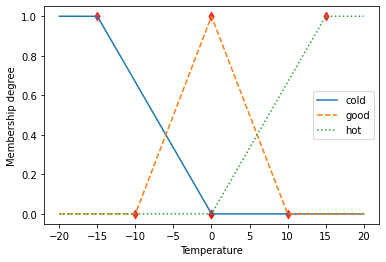

In [20]:
# Linguistic variables temp
temp_t1 = fs.FuzzySet(points=[[-15., 1.],  [0., 0.]], term="cold")
temp_t2 = fs.FuzzySet(points=[[-10., 0.],  [0., 1.], [10., 0.]], term="good")
temp_t3 = fs.FuzzySet(points=[[0., 0.],  [15., 1.]], term="hot")
temp_lv = fs.LinguisticVariable([temp_t1, temp_t2, temp_t3], universe_of_discourse=[-20, 20],
                                concept="Temperature")
# Add the linguistic variable to the system
FC.add_linguistic_variable("temp", temp_lv)

# Plot the variable
FC.plot_variable("temp")

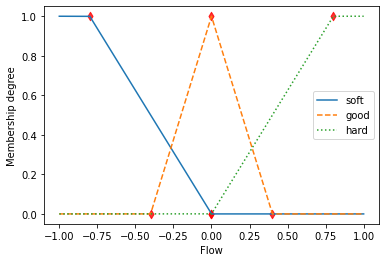

In [21]:
# Linguistic variable flow
flow_f1 = fs.FuzzySet(points=[[-.8, 1.],  [0., 0.]], term="soft")
flow_f2 = fs.FuzzySet(points=[[-.4, 0.],  [0., 1.], [.4, 0.]], term="good")
flow_f3 = fs.FuzzySet(points=[[0., 0.],  [0.8, 1.]], term="hard")
flow_lv = fs.LinguisticVariable([flow_f1, flow_f2, flow_f3], universe_of_discourse=[-1, 1],
                                concept="Flow")
# Add the linguistic variable to the system
FC.add_linguistic_variable("flow", flow_lv)

# Plot the variable
FC.plot_variable("flow")

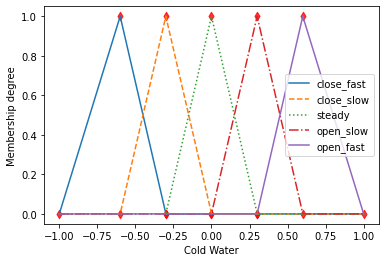

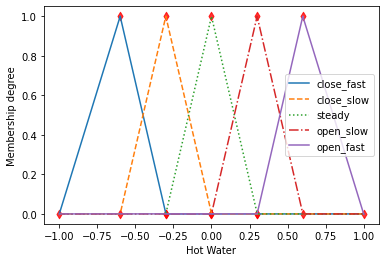

In [22]:
# Linguistic variable for hot water and cold water
water_o1 = fs.FuzzySet(points=[[-1., 0.], [-.6, 1.], [-.3, 0.]], term="close_fast")
water_o2 = fs.FuzzySet(points=[[-.6, 0.], [-.3, 1.], [0., 0.]], term="close_slow")
water_o3 = fs.FuzzySet(points=[[-.3, 0.], [0., 1.], [.3, 0.]], term="steady")
water_o4 = fs.FuzzySet(points=[[0., 0.], [.3, 1.], [.6, 0.]], term="open_slow")
water_o5 = fs.FuzzySet(points=[[.3, 0.], [.6, 1.], [1., 0.]], term="open_fast")
water_hot = fs.LinguisticVariable([water_o1, water_o2, water_o3, water_o4, water_o5], universe_of_discourse=[-1, 1],
                                  concept="Cold Water")
water_cold = fs.LinguisticVariable([water_o1, water_o2, water_o3, water_o4, water_o5], universe_of_discourse=[-1, 1],
                                   concept="Hot Water")
# Add the linguistic variable to the system
FC.add_linguistic_variable("hot", water_hot)
FC.add_linguistic_variable("cold", water_cold)

# Plot the variable
FC.plot_variable("hot")
FC.plot_variable("cold")

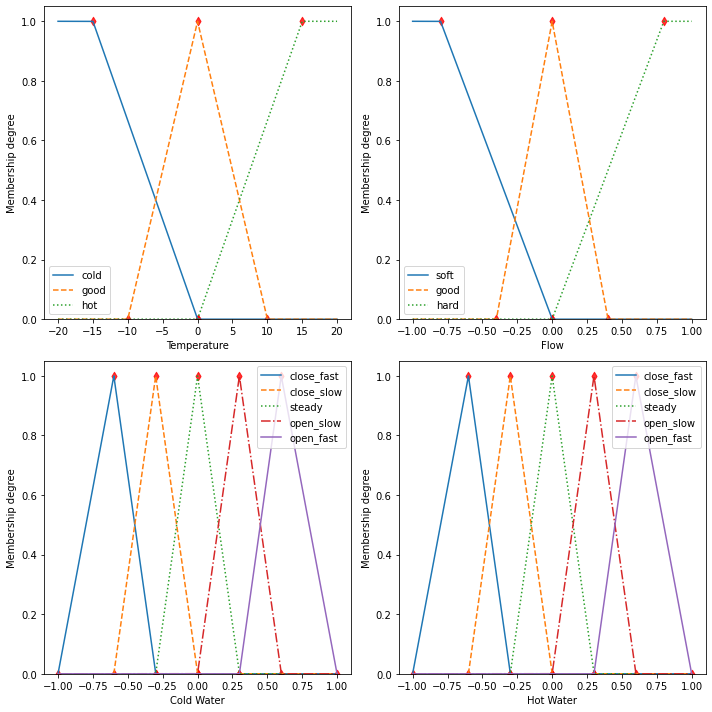

In [23]:
# Make a figure to see all the linguistic variables (used in the hand-in)
FC.produce_figure("controller_ling_var.png", max_figures_per_row=2)

### Rulebase
Define the rulebase for the controller.

In [24]:
# Rule base for the system
R1 = "IF (temp IS cold) AND (flow IS soft) THEN (cold IS open_slow)"
R2 = "IF (temp IS cold) AND (flow IS soft) THEN (hot IS open_fast)"

R3 = "IF (temp IS cold) AND (flow IS good) THEN (cold IS close_slow)"
R4 = "IF (temp IS cold) AND (flow IS good) THEN (hot IS open_slow)"

R5 = "IF (temp IS cold) AND (flow IS hard) THEN (cold IS close_fast)"
R6 = "IF (temp IS cold) AND (flow IS hard) THEN (hot IS close_slow)"

R7 = "IF (temp IS good) AND (flow IS soft) THEN (cold IS open_slow)"
R8 = "IF (temp IS good) AND (flow IS soft) THEN (hot IS open_slow)"

R9 = "IF (temp IS good) AND (flow IS good) THEN (cold IS steady)"
R10 = "IF (temp IS good) AND (flow IS good) THEN (hot IS steady)"

R11 = "IF (temp IS good) AND (flow IS hard) THEN (cold IS close_slow)"
R12 = "IF (temp IS good) AND (flow IS hard) THEN (hot IS close_slow)"

R13 = "IF (temp IS hot) AND (flow IS soft) THEN (cold IS open_fast)"
R14 = "IF (temp IS hot) AND (flow IS soft) THEN (hot IS open_slow)"

R15 = "IF (temp IS hot) AND (flow IS good) THEN (cold IS open_slow)"
R16 = "IF (temp IS hot) AND (flow IS good) THEN (hot IS close_slow)"

R17 = "IF (temp IS hot) AND (flow IS hard) THEN (cold IS close_slow)"
R18 = "IF (temp IS hot) AND (flow IS hard) THEN (hot IS close_fast)"

rule_base = [R1, R2, R3, R4, R5, R6, R7, R8, R9, R10, R11, R12, R13, R14, R15, R16, R17, R18]
FC.add_rules(rule_base)

Set the crisp outputs if sugeno inference is enabled

In [25]:
# set the crisp outputs
if enable_sugeno:
    FC.set_crisp_output_value("close_fast", -0.6)
    FC.set_crisp_output_value("close_slow", -0.3)
    FC.set_crisp_output_value("steady", 0.)
    FC.set_crisp_output_value("open_slow", 0.3)
    FC.set_crisp_output_value("open_fast", 0.6)

Calculating subplot |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


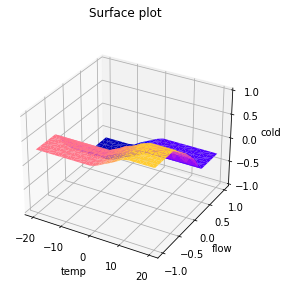

Calculating subplot |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


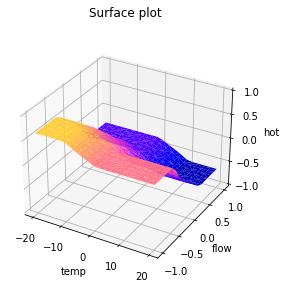

In [26]:
surface_plot_3d(FC, ["temp", "flow", "cold"], [[-20, 20], [-1, 1], [-1, 1]], sugeno=enable_sugeno)
surface_plot_3d(FC, ["temp", "flow", "hot"], [[-20, 20], [-1, 1], [-1, 1]], sugeno=enable_sugeno)

### CLASS: WaterValve
The following section is used to make a class for the water valves.

In [27]:
# Make the class for the water valves
class WaterValve:
    """
    Class to simulate a water valve
    """
    max_valve_pos = 2

    def __init__(self, water_temp, max_flow, sample_time):
        """
        :param water_temp: what is the temperature of the water
        :param max_flow: Set the max flow rate
        :param sample_time: Sample time in seconds, used to integrate
        """
        self.time_step = sample_time
        self.max_flow = max_flow
        self.temp = water_temp
        # Set start params
        self.valve_pos = 0.1
        self.valve_input = 0
        self.flow = 0


    def update_outputs(self):
        """
        Function to update the outputs for the valve.
        Updates the position and the flow.
        """
        self.set_new_pos()
        self.set_flow()

    """SETTERS"""
    def set_new_pos(self):
        """
        Sets a new position to the valve based on the input and sample time.
        """
        # Integrate the input, and add this to the position
        self.valve_pos += self.valve_input*self.time_step
        # Override the valve position if its over max
        if self.valve_pos > WaterValve.max_valve_pos:
            self.valve_pos = WaterValve.max_valve_pos

    def set_input(self, value):
        """
        Set a new value to the control input for the valve
        :param value: new value
        """
        self.valve_input = value

    def set_flow(self):
        """
        Set a new flow value based on the position of the valve and the max flow rate.
        """
        # The flow is calculated based on the valve position, but can not be over the max flow
        self.flow = self.valve_pos*(self.valve_pos <= self.max_flow)
        self.flow += self.max_flow*(self.valve_pos > self.max_flow)

    """GETTERS"""
    def get_flow(self):
        return self.flow

    def get_temp(self):
        return self.temp


### Setup for the simulation

In [28]:
# set the parameters for the simulation time
sample_time = 0.01
start_time = 0
stop_time = 50
samples = int((stop_time-start_time)/sample_time + 1)

time = np.linspace(start_time, stop_time, samples)

# Make the setpoints as square waves
flow_setpoint = 0.7 - .2*sig.square(0.3*time)
temp_setpoint = 23 - 4*sig.square(0.214320*time)
temp = np.zeros(time.size)
flow = np.zeros(time.size)

# Make the water valves
hot_valve = WaterValve(30, 2, sample_time)
cold_valve = WaterValve(10, 2, sample_time)

### Run the simulation

In [29]:
# Loop thru the computation for every timestep
for t in np.arange(time.size):
    # Compute the flow rate
    cold_valve.update_outputs()
    hot_valve.update_outputs()
    flow[t] = hot_valve.get_flow() + cold_valve.get_flow()
    # Compute the temp
    temp[t] = (hot_valve.get_flow()*hot_valve.get_temp() + cold_valve.get_flow()*cold_valve.get_temp())/(flow[t])

    # Calculate the error values
    flow_error = flow[t] - flow_setpoint[t]
    temp_error = temp[t] - temp_setpoint[t]

    # Compute the outputs
    FC.set_variable("temp", temp_error)
    FC.set_variable("flow", flow_error)
    if enable_sugeno:
        output = FC.Sugeno_inference(["cold", "hot"])
    else:
        output = FC.Mamdani_inference(["cold", "hot"])

    # Set the new inputs for the water valves
    cold_valve.set_input(output["cold"])
    hot_valve.set_input(output["hot"])

    # Print progress bar
    percent = ("{0:." + str(1) + "f}").format(100 * (time[t] / float(time[-1])))
    filledLength = int(100 * time[t] // time[-1])
    bar = '█' * filledLength + '-' * (100 - filledLength)
    print(f'\r{"Simulating"} |{bar}| {percent}% {"generated"}', end="\r")

### Present the results

The max temperature is:  28.528236180465527
and happend at the time:  22.02


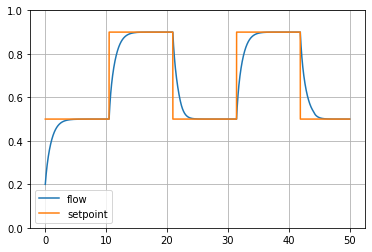

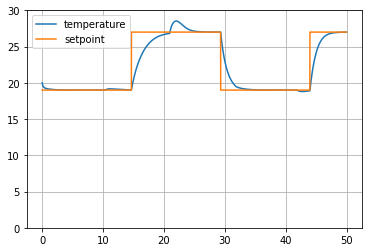

In [30]:
# Make a plot for the flow and flow setpoint
plt.figure()
plt.plot(time, flow)
plt.plot(time, flow_setpoint)
plt.ylim([0, 1])
plt.legend(["flow", "setpoint"])
plt.grid(True)

# Make a plot for the temperature and temperature setpoint
plt.figure()
plt.plot(time, temp, label="temperature")
plt.plot(time, temp_setpoint, label="setpoint")
plt.ylim([0, 30])
plt.legend(["temperature", "setpoint"])
plt.grid(True)

# Print the max temperature, to compare with the result from MATLAB
print("The max temperature is: ", temp.max())
print("and happend at the time: ", time[np.where(temp == temp.max())[0][0]])